In [33]:
import os
import pandas as pd
import PIL
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def read_json(filepath: str):
    with open(filepath) as f:
        data = json.load(f)
    return data

In [4]:
DATA_PATH = '../data'

In [6]:
train = read_json(os.path.join(DATA_PATH, "train_all.json"))

In [28]:
heights = [x['height'] for x in train['images']]
widths = [x['width'] for x in train['images']]

print(f"keys: {train.keys()}")
print(f"Number of images: {len(train['images'])}")
print(f"Number of categories: {len(train['categories'])}")
print(f"Number of annotation = {len(train['annotations'])}")
print('Max min avg height: ', max(heights), min(heights), int(sum(heights)/len(heights)))
print('Max min avg width: ', max(widths), min(widths), int(sum(widths)/len(widths)))

keys: dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])
Number of images: 3272
Number of categories: 10
Number of annotation = 26240
Max min avg height:  512 512 512
Max min avg width:  512 512 512


In [19]:
train['annotations'][0].keys()

dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd'])

## 이미지당 객체 수

In [29]:
img2nboxes = {} # mapping "image id" to "number of boxes"

for ann in train['annotations']:
    img_id = ann['image_id']
    
    if img_id in img2nboxes.keys():
        img2nboxes[img_id] += 1
    else:
        img2nboxes[img_id] = 1

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

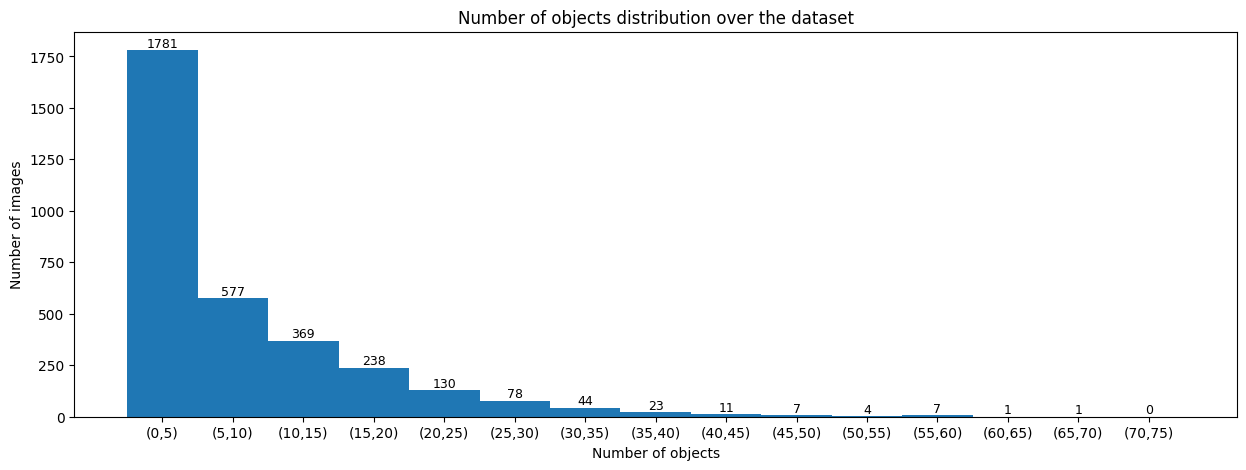

Number of images having atleast one box:  3271
Min number of boxes per image:  1
Max number of boxes per image:  70
Avg number of boxes per image:  8


In [34]:
out = pd.cut(nboxes_list, bins=np.arange(0,max_nboxes+10,5), include_lowest=True)

counts = out.value_counts().values
labels = [(int(i.left),int(i.right)) for i in out.value_counts().index.categories]

graph_xind = [i[0] for i in labels] 
ticks = [ '('+str(i[0])+','+ str(i[1])+')' for i in labels]

plt.figure(figsize=(15,5))
plt.bar(graph_xind, counts, tick_label=ticks, width=5)
for i, v in enumerate(graph_xind):
    plt.text(v, counts[i], counts[i],                 
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')   
plt.xlabel('Number of objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution over the dataset')
plt.show()

print("Number of images having atleast one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

In [39]:
# Class distribution
for current_id in range(3271):
    class2nboxes = {} 
    for ann in train['annotations']:
        cat_id = ann['category_id']
        img_id = ann['image_id']
        if cat_id in class2nboxes.keys() and img_id == current_id:
            class2nboxes[cat_id] += 1
        elif cat_id not in class2nboxes.keys() and img_id == current_id:
            class2nboxes[cat_id] = 1
        elif cat_id not in class2nboxes.keys():
            class2nboxes[cat_id] = 0

        
    sorted_c2nb = [(k,v)for k, v in sorted(class2nboxes.items(), reverse=False, key=lambda item: item[0])]

    # to plot
    categ_map = {x['id']: x['name'] for x in train['categories']}
    y = [i[1] for i in sorted_c2nb]
    x = [i[0] for i in sorted_c2nb]
    x = [categ_map[k] for k in x]
    plt.figure(figsize=(14,5))
    plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='royalblue')
    plt.xlim(-0.5,len(y))
    plt.xlabel('Category Id')
    plt.ylabel('Number of classes')
    plt.title(f'Class distribution of {current_id}')
    plt.savefig(f'{current_id}_class_distriubtion')
    #plt.show()
    plt.close() #prevent memory issues

KeyboardInterrupt: 

## 박스 크기

In [36]:
# Class wise bounding box area distribution

bbox_areas = {} # key: class index, value -> a list of bounding box areas

for ann in train['annotations']:
    area = ann['area']
    cat_id = ann['category_id']
    
    if area <= 0.0:
        continue
    
    if cat_id in bbox_areas.keys():
        bbox_areas[cat_id].append(area)
    else:
        bbox_areas[cat_id] = [area]


bbox_avg_areas = []

for cat in bbox_areas.keys():
    areas = bbox_areas[cat]
    avg_area = int(sum(areas)/len(areas))
    
    bbox_avg_areas.append((cat,avg_area))

bbox_avg_areas = sorted(bbox_avg_areas, key = lambda x: x[1])

1 -> General trash, 2 -> Paper, 3 -> Paper pack, 4 -> Metal, 5 -> Glass, 6 -> Plastic, 7 -> Styrofoam, 8 -> Plastic bag, 9 -> Battery, 10 -> Clothing, 

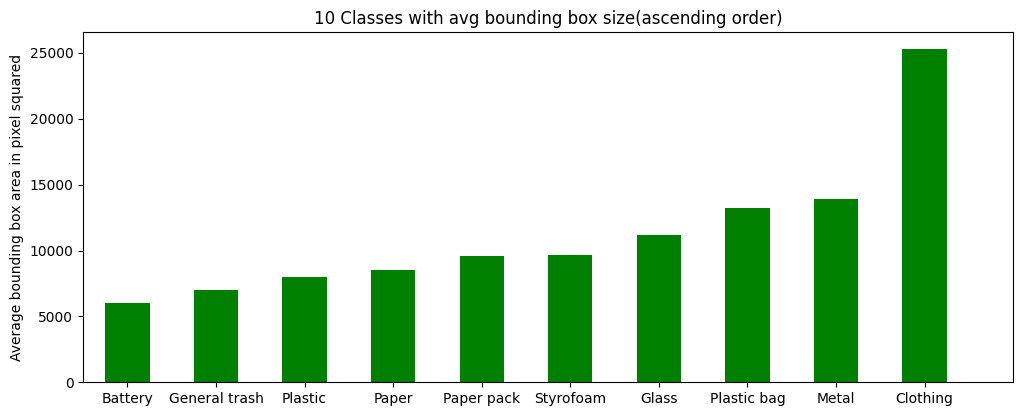

In [40]:
top = min(10, len(bbox_avg_areas))

plt.figure(figsize=(12,10))

categ_map = {x['id']: x['name'] for x in train['categories']}
y2 = [item[1] for item in bbox_avg_areas[:top]]
x2 = [item[0] for item in bbox_avg_areas[:top]]
x2 = [categ_map[k] for k in x2]
plt.subplot(211)
plt.bar(np.arange(len(y2)),y2, width=0.5,tick_label=x2,color='green')
plt.xlim(-0.5,len(y))
# plt.xlabel('Category Id')
plt.ylabel('Average bounding box area in pixel squared')
plt.title(str(top)+ ' Classes with avg bounding box size(ascending order)')


for k in categ_map.keys():
    print(k,'->',categ_map[k], end=", ")

## 클래스 객체 수 확인

{8: 7643, 6: 3090, 5: 610, 1: 2782, 4: 562, 2: 9311, 3: 659, 7: 1343, 10: 177, 9: 63}


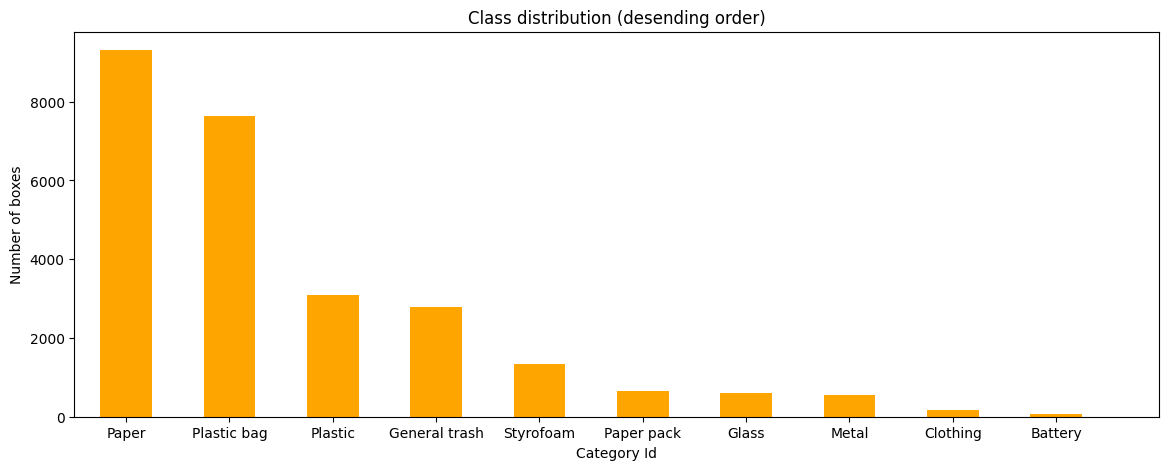

1 -> General trash, 2 -> Paper, 3 -> Paper pack, 4 -> Metal, 5 -> Glass, 6 -> Plastic, 7 -> Styrofoam, 8 -> Plastic bag, 9 -> Battery, 10 -> Clothing, 

In [42]:
# Class distribution
image_class2nboxes = {} 

for ann in train['annotations']:
    cat_id = ann['category_id']
    
    if cat_id in image_class2nboxes.keys():
        image_class2nboxes[cat_id] += 1
    else:
        image_class2nboxes[cat_id] = 1
print(image_class2nboxes)
sorted_c2nb = [(k,v)for k, v in sorted(image_class2nboxes.items(), reverse=True, key=lambda item: item[1])]

# top 20 classes
top = min(len(sorted_c2nb),20)

# to plot
categ_map = {x['id']: x['name'] for x in train['categories']}
y = [i[1] for i in sorted_c2nb[:top]]
x = [i[0] for i in sorted_c2nb[:top]]
x = [categ_map[k] for k in x]
plt.figure(figsize=(14,5))
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='orange')
plt.xlim(-0.5,len(y))
plt.xlabel('Category Id')
plt.ylabel('Number of boxes')
plt.title('Class distribution (desending order)')
plt.show()



for k in categ_map.keys():
    print(k,'->',categ_map[k], end=", ")

- 일쓰
    - 형태
    - 색깔
    - 명암

In [57]:
import torch
from torch.utils.data import Dataset
import cv2

from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2

category_names = ['General trash','Paper','Paper pack','Metal','Glass','Plastic','Styrofoam','Plastic bag','Battery', 'Clothing']

/opt/conda/envs/mmseg/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [123]:
dataset_path  = '/opt/ml/input/data'

In [125]:
def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        self.ids = list(sorted(self.coco.imgs.keys()))
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=self.ids[index])
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
        anns = self.coco.loadAnns(ann_ids)

        # Load the categories in a variable
        cat_ids = self.coco.getCatIds()
        cats = self.coco.loadCats(cat_ids)

        # Background = 0
        masks = np.zeros((image_infos["height"], image_infos["width"]))
        # General trash = 1, ... , Cigarette = 10
        anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
        for i in range(len(anns)):
            className = get_classname(anns[i]['category_id'], cats)
            pixel_value = category_names.index(className)
            masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
        masks = masks.astype(np.int8)
                    
        if self.transform is not None:
            transformed = self.transform(image=images, mask=masks)
            images = transformed["image"]
            masks = transformed["mask"]
        return images, masks, image_infos
    
    def __len__(self) -> int:
        return len(self.coco.getImgIds())

In [126]:
train_path = dataset_path + '/train_all.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

batch_size = 1  

train_transform = A.Compose([
                            ToTensorV2()
                            ])

train_dataset = CustomDataLoader(data_dir=train_path, transform=train_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=4,
                                           collate_fn=collate_fn)

loading annotations into memory...
Done (t=4.84s)
creating index...
index created!


In [172]:
cate_masks = {i:np.zeros((512, 512, 1)) for i in range(10)}
    
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]

    masks = masks[0].numpy()
    
    for i in range(10):
        cate_masks[i][masks == i] += 1


In [191]:
for i in range(10):
    file_dir = f"/opt/ml/input/EDA/cate_shape/{category_names[i]}.png"
    max_mask = np.max(cate_masks[i]) / 255
    img = (cate_masks[i]/max_mask)
    cv2.imwrite(file_dir, img)